# Multivariate Gaussian Mixture inference using CAVI

## 1. Overview of the model and the inference formulas

This a generalization of the Gaussian Mixture example shown in the paper from D. M. Blei, A. Kucukelbir, and J. D. McAuliffe, “Variational Inference: A Review for Statisticians”, https://arxiv.org/abs/1601.00670. Instead of using the Univariate Gaussian Mixture we introduce the Multivariate Gaussian Mixture and apply the CAVI (Coordinate ascent (mean-field) variational inference) for our inference. 

The Gaussian Mixture we will be using has this form:

$$\mu_k\sim \mathcal{N}(\alpha,\sigma^2I)\quad k=1,...,K\\ c_i\sim Categorical(\frac{1}{K},...,\frac{1}{K})\quad i=1,...,N\\x_i|c_i,\mu\sim \mathcal{N}(c_i^T\mu,\lambda^2I) \quad i=1,...,N$$

Calculating ELBO
Term 1:
$$\sum_{k=1}^KE_q[logp(\mu_k)]=-\frac{1}{2\sigma^2}\sum_{k=1}^{K}[ps_k^2+m_k^Tm_k-2m_k^T\alpha+\alpha^T\alpha]-\frac{Kp}{2}log2\pi\sigma^2$$

Calculating ELBO Term 2:
$$\sum_{i=1}^NE_q[logp(c_i)]=-NlogK$$

Calculating ELBO Term 3:
$$\sum_{i=1}^NE_q[logp(x_i|c_i,\mu)]=\\=\sum_{i=1}^N\sum_{k=1}^K-\frac{p}{2}log(2\pi\lambda^2)\phi_{ik}-\frac{1}{2\lambda^2}\sum_{i=1}^{N}\sum_{k=1}^{K}\phi_{ik}(x_i^Tx_i-2x_i^Tm_k+ps_k^2+m_k^Tm_k)$$

Calculating ELBO Term 4:
$$\sum_{k=1}^KE_q[logq(\mu_k)]=-\frac{p}{2}\sum_{k=1}^Klog(2\pi s_k^2)-\frac{Kp}{2}$$

Calculating ELBO Term 5:
$$\sum_{i=1}^{N}E_q[logq(c_i)]=\sum_{i=1}^{N}\sum_{k=1}^{K}\phi_{ik}log\phi_{ik}$$

Term update for $m_k$ and $s_k^2$:
$$s_k^2=\frac{\sigma^2\lambda^2}{\sigma^2\sum_{i=1}^{N}\phi_{ik}+\lambda^2}\\m_k=\frac{\sigma\sum_{i=1}^{N}\phi_{ik}x_i}{\sigma\sum_{i=1}^{N}\phi_{ik}+\lambda^2}$$

Term update for $\phi_{ik}$:
$$\phi_{ik}\propto exp\{\frac{x_i^TE_{q_\mu}[\mu_k]}{\lambda^2}-\frac{E_{q_\mu}[\mu_k^T\mu_k]}{2\lambda^2}\} =\\= exp\{\frac{x_i^Tm_k}{\lambda^2}-\frac{m_k^Tm_k+ps_k^2}{2\lambda^2}\}$$

## 2. Implementation



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import seaborn as sns
from matplotlib.patches import Ellipse
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [2]:
class MGMM:
    def __init__(self, X, K=2, sigma=1,lmbda=1, alpha=np.array([1,1])):
        self.X=X
        self.K=K
        self.N=self.X.shape[0]
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min())+1, high=int(self.X.max()), size=(self.K, self.X.shape[1])).astype(float)
        self.s2 = np.random.random((self.K,))
        self.p = self.X.shape[1]
        self.alpha = alpha
        self.sigma=sigma
        self.lmbda=lmbda
    
    def elbo(self):
        t1 = -1/(2*self.sigma**2)*(self.p * self.s2 + np.einsum('ij,ij->i', self.m, self.m) - 2 * np.einsum('ij,j->i', self.m, self.alpha) + self.alpha.T.dot(self.alpha)).sum()-((self.K*self.p)/2)-math.log(2*math.pi*self.sigma**2)
        t2 = -self.N * math.log(self.N)
        t3 = -(self.p/2) * math.log(2 * math.pi * self.lmbda**2) * self.phi.sum()-(1/(2*self.lmbda**2)) * (np.einsum('ij,ij,ik->ik',self.X, self.X, self.phi).sum(1)-2 * np.einsum('ij,kj,ik->ik',self.X,self.m,self.phi).sum(1) + self.p * np.einsum('k,ik->ik',self.s2,self.phi).sum(1)).sum() 
        t4 = -(self.p/2) * np.log(2 * math.pi * self.s2).sum() - (self.K * self.p)/2
        t5 = np.einsum('ik,ik->',self.phi,np.log(self.phi))
        elbo = t1 + t2 + t3 + t4 + t5 
        return elbo
    
    def _update_m_s(self):
        self.m = self.sigma * (np.einsum('ik,ij->kj',self.phi,self.X))/(self.sigma * self.phi.sum(0)[:,np.newaxis] + self.lmbda**2)
        assert self.m.shape[0] == self.K

        self.s2 = (self.sigma**2 * self.lmbda**2)/(self.sigma**2 * self.phi.sum(0) + self.lmbda**2)
        assert self.s2.size == self.K
        
    def _update_phi(self):
        exponent = np.einsum('ij,kj->ik',self.X,self.m)/(self.lmbda**2) - ((np.einsum('kj,kj->k',self.m,self.m) + self.p * self.s2)/(2 * self.lmbda**2))
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]
        self.phi[self.phi==0.0]=10**-10
        
    def fit(self, max_iter=100, t=1e-10):
        self.elbo_values = [self.elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._update_phi()
            self._update_m_s()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= t:
                print('ELBO converged with ELBO {:.3f} at iteration {:d}'.format(self.elbo_values[-1],
                                                                     iter_))
                break
        if iter_ == max_iter:
            print('ELBO ended with ELBO {:.3f}'.format(self.elbo_values[-1]))

In [3]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellip)
    #ax.set_aspect('equal')
    ax.autoscale()
    return ellip

In [4]:
components = 3
dimensions = 2
sample = 1000
mean = np.random.random((components, dimensions)) * 10   +  np.random.randint(-10,10, size=(components,dimensions))
s = np.random.random((components,)) * 10-5
X=np.random.multivariate_normal(mean[0,:], (s[0]**2) * np.identity(dimensions), size=sample)
for i in range(1,components):
    X=np.append(X,np.random.multivariate_normal(mean[i,:], (s[i]**2) * np.identity(dimensions), size=sample), axis=0)

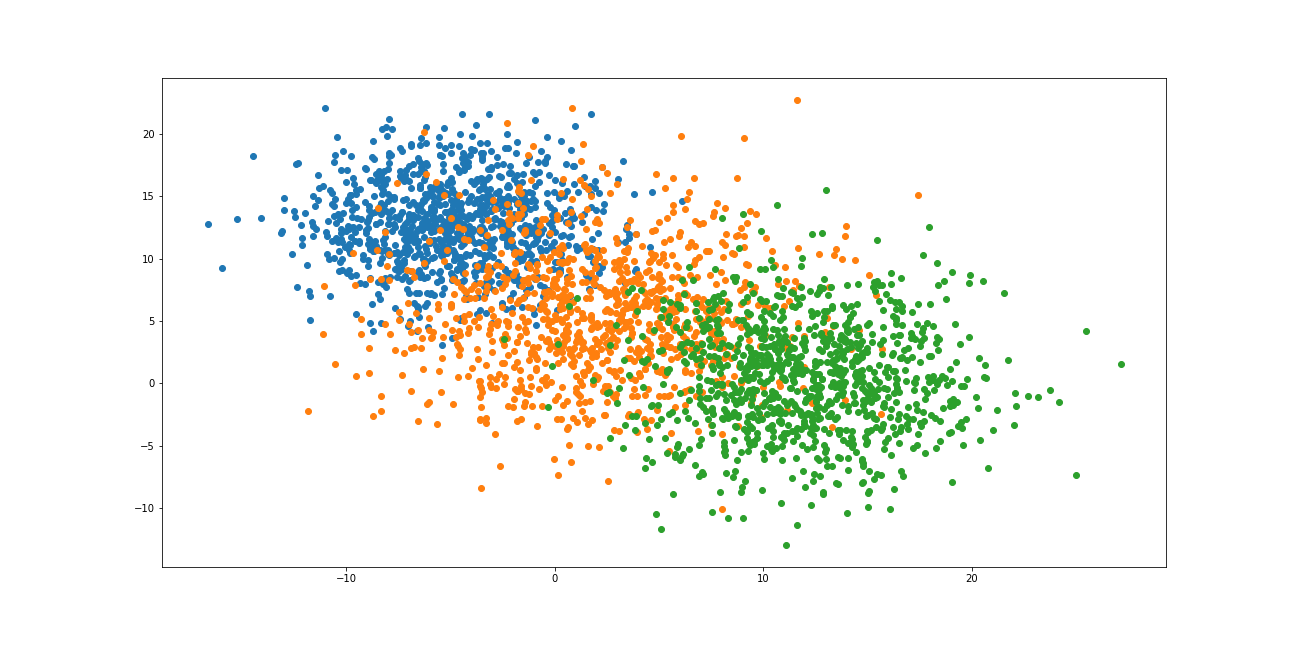

In [5]:
plt.subplots(figsize=(18, 9))
plt.scatter(X[:sample,0], X[:sample,1])
plt.scatter(X[sample:2*sample,0], X[sample:2*sample,1])
plt.scatter(X[2*sample:,0], X[2*sample:,1])
plt.show()

In [6]:
cavi=MGMM(X, K=components)

In [7]:
cavi.fit()

5 [[ 1.78669368  5.12971544]
 [-4.90461014 13.04813456]
 [12.13797332  0.38582848]]
10 [[ 2.48991309  4.8213109 ]
 [-4.79722888 12.7638308 ]
 [12.47016444  0.18875022]]
15 [[ 2.54536478  4.78883562]
 [-4.78440686 12.74434291]
 [12.50253339  0.17352272]]
20 [[ 2.54895869  4.78633863]
 [-4.78345023 12.74298193]
 [12.50474521  0.17276762]]
25 [[ 2.54921547  4.78615865]
 [-4.78338129 12.74288417]
 [12.50490353  0.17271464]]
30 [[ 2.54923393  4.78614571]
 [-4.78337633 12.74287714]
 [12.50491492  0.17271083]]
35 [[ 2.54923526  4.78614478]
 [-4.78337597 12.74287663]
 [12.50491573  0.17271056]]
40 [[ 2.54923535  4.78614471]
 [-4.78337594 12.7428766 ]
 [12.50491579  0.17271054]]
45 [[ 2.54923536  4.7861447 ]
 [-4.78337594 12.74287659]
 [12.5049158   0.17271054]]
50 [[ 2.54923536  4.7861447 ]
 [-4.78337594 12.74287659]
 [12.5049158   0.17271054]]
55 [[ 2.54923536  4.7861447 ]
 [-4.78337594 12.74287659]
 [12.5049158   0.17271054]]
ELBO converged with ELBO 118378.941 at iteration 56


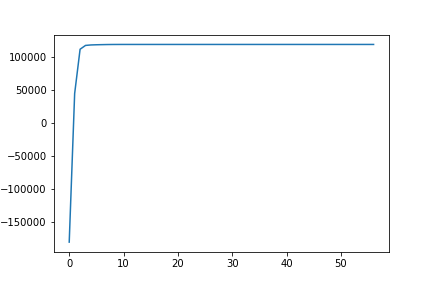

In [8]:
plt.plot(cavi.elbo_values)
plt.show()

In [9]:
mu = np.random.multivariate_normal(cavi.m[0,:], (cavi.s2[0]) * np.identity(dimensions))[np.newaxis,:]
Z = {}
Z[0]=[]
for i in range(1,components):
    mu=np.append(mu,np.random.multivariate_normal(cavi.m[i,:], (cavi.s2[i]) * np.identity(dimensions))[np.newaxis,:], axis=0)
    Z[i]=[]
for j in range(X.shape[0]):
    Z[np.argmax(cavi.phi[j,:])].append(X[j,:][np.newaxis,:])
for i in range(components):
    Z[i] = np.concatenate(Z[i], axis=0)

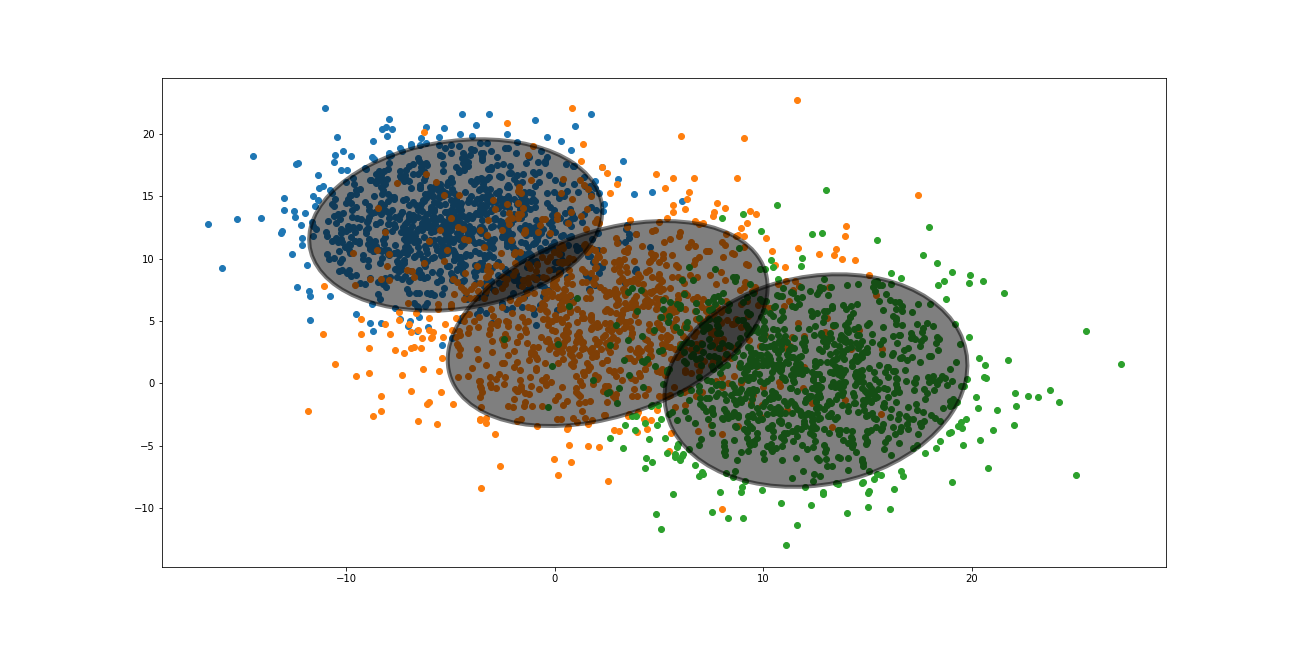

In [10]:
fig, ax= plt.subplots(figsize=(18, 9))
ax.scatter(X[:sample,0], X[:sample,1])
ax.scatter(X[sample:2*sample,0], X[sample:2*sample,1])
ax.scatter(X[2*sample:,0], X[2*sample:,1])
for i in range(components):
    pos=mu[i,:]
    cov= np.cov(Z[i].T)
    plot_cov_ellipse(cov, pos, nstd=2,  alpha=0.5, edgecolor='black', lw=4, facecolor='black')